In [1]:
import pandas as pd
%pip install requests
import requests
# USGSから過去1か月の地震データを取得
url = "https://earthquake.usgs.gov/earthquakes/feed/v1.0/summary/all_month.csv"
response = requests.get(url)

# データをファイルに保存
with open('earthquakes.csv', 'wb') as file:
    file.write(response.content)

# データをDataFrameに読み込む
data = pd.read_csv('earthquakes.csv')

# データの最初の5行を表示
data.head(100)

ImportError: C extension: pandas.util not built. If you want to import pandas from the source directory, you may need to run 'python setup.py build_ext' to build the C extensions first.

In [ ]:
# 国ごとの地震発生頻度ランキングと最大マグニチュードランキングを作成し、合計ポイントで順位付け
# 地震データには国情報が直接含まれていないため、place列から国名を抽出
#str.split(",").str[-1]でカンマ区切りの最後の部分を国名として抽出
data["country"] = data["place"].str.split(",").str[-1]
# 国ごとの地震発生頻度ランキング作成
ranking = data["country"].value_counts().head(10)

# 頻度ランキングのデータフレーム化
ranking_df = ranking.reset_index()
ranking_df.columns = ["country", "count"]
# ランキングを1から始める
ranking_df.index += 1

# 頻度に基づくポイント付与（頻度が高いほど高ポイント）
# 頻度ランキングの順位を逆にしてポイントを計算
ranking_df["point"] = ranking_df["count"].rank(method="min", ascending=False).astype(int)
# 高い頻度に高いポイントを与えるために、最大ポイントから引く
ranking_df["point"] = ranking_df["point"].max() - ranking_df["point"] + 1

# 最大マグニチュードランキング作成
# 国ごとの最大マグニチュード上位10か国を抽出
ranking_mag = data.sort_values("mag", ascending=False)[["mag", "country"]].head(10)
ranking_mag = ranking_mag.reset_index(drop=True)
# ランキングを1から始める
ranking_mag.index += 1
# マグニチュードに基づくポイント付与（マグニチュードが高いほど高ポイント）
# 高いマグニチュードに高いポイントを与えるために、ランキングの逆順でポイントを計算
ranking_mag["point"] = ranking_mag.index.map(lambda x: 11 - x)

# 頻度ポイントとマグニチュードポイントを合算して最終ランキングを作成
# 外部結合で両方のポイントを結合
merged = pd.merge(ranking_df, ranking_mag[["country", "point"]], on="country", how="outer", suffixes=("_freq", "_mag"))

# 空白を0に置換
merged = merged.fillna(0)

# 合計ポイントを計算
merged["total_point"] = merged["point_freq"] + merged["point_mag"]

# 各国の最大マグニチュードを取得
max_mag_per_country = data.groupby("country")["mag"].max().reset_index()
# 列名を変更
max_mag_per_country.columns = ["country", "max_mag"]

# 最終ランキングに最大マグニチュードを追加
final_ranking = pd.merge(merged, max_mag_per_country, on="country", how="left")
# データ型を整数に変換
final_ranking["total_point"] = final_ranking["total_point"].astype(int)
final_ranking["point_freq"] = final_ranking["point_freq"].astype(int)
final_ranking["point_mag"] = final_ranking["point_mag"].astype(int)

# 合計ポイントで並び替え
final_ranking = final_ranking.sort_values("total_point", ascending=False).reset_index(drop=True)

# ランキングを1から始める
final_ranking.index += 1
# 最終ランキングの上位10か国を表示
print("\n\n=== 合計ポイント  頻度 + 最大マグニチュード ランキング ===\n")
print(final_ranking[["country", "count", "max_mag", "point_freq", "point_mag", "total_point"]].head(10))





=== 合計ポイント  頻度 + 最大マグニチュード ランキング ===

         country   count  max_mag  point_freq  point_mag  total_point
1          Japan     0.0     6.80           0         10           10
2             CA  2356.0     3.83           9          0            9
3      Indonesia     0.0     6.50           0          9            9
4     Guadeloupe     0.0     6.50           0          8            8
5         Alaska  1943.0     5.40           8          0            8
6          Texas   573.0     3.20           7          0            7
7      Banda Sea     0.0     6.40           0          7            7
8          Japan     0.0     6.80           0          6            6
9     Washington   196.0     2.85           6          0            6
10   Afghanistan     0.0     6.30           0          5            5


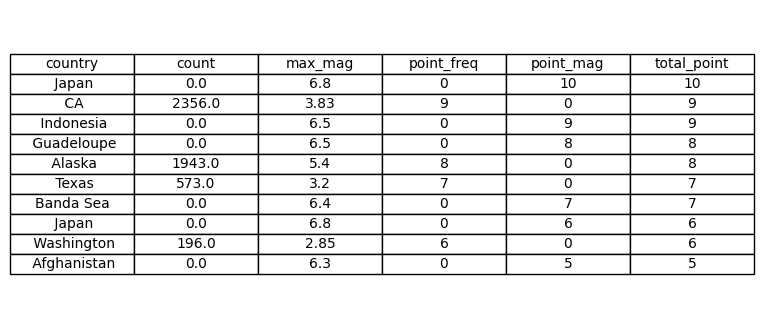

In [ ]:
import matplotlib.pyplot as plt

# 表示したいデータ（上位10件だけ）
table_data = final_ranking[["country", "count", "max_mag", "point_freq", "point_mag", "total_point"]].head(10)

# 図を作成
fig, ax = plt.subplots(figsize=(8, 4))
ax.axis('tight')
ax.axis('off')

# 表を作成
table = ax.table(cellText=table_data.values,
                 colLabels=table_data.columns,
                 cellLoc='center',
                 loc='center')

# 表のスタイルを整える
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)

# 画像として保存
plt.savefig("ranking_table.png", bbox_inches='tight', dpi=300)
plt.show()
